# DeepLabV3+ Transfer Learning Training Demo

DeepLabV3+ with interchangeable backbone transfer learning training demo
Net pretrained with COCO val2017, then fine-tuned with Yamaha-CMU Off-Road Dataset

---

Author: **Nate Haddad** nhaddad2112[at]gmail[dot]com

In [23]:
import os
import os.path as op
import sys

import torch
from torchvision import models
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
import numpy as np
from PIL import Image
import yaml

sys.path.append('..')
from utils import get_dataloader, Trainer, display_example_pair

In [24]:
torch.cuda.is_available()

False

In [25]:
np.random.seed(42)

Set up all of our path variables and hyperparamters needed to train the model. Adjust accordingly to your needs

In [26]:
with open('../config/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

Set up the `data` and `model` directories

In [27]:
if not op.exists('../data'):
    os.makedirs('../data')
    
if not op.exists('../models'):
    os.makedirs('../models')

---

**IMPORTANT:** we require that you now download the Yamaha CMU Off-Road Dataset from the following url before proceding. The directory and files should be unzipped and placed in the `data` directory of this repository, created above.

**Link to download dataset:** https://theairlab.org/yamaha-offroad-dataset/

---

Load an example image from the training set

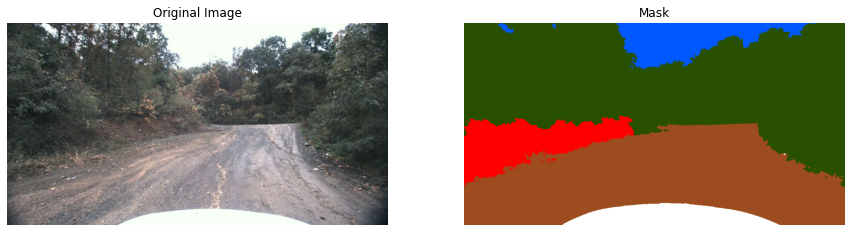

In [28]:
example_image = Image.open(op.join('..', config['DATA_PATH'], 'train/iid000008/rgb.jpg'))
example_mask = Image.open(op.join('..', config['DATA_PATH'], 'train/iid000008/labels.png'))
image_display = np.array(example_image)
mask_display = np.array(example_mask.convert('RGB'))
display_example_pair(image_display, mask_display)

Load data into dataloaders

In [38]:
dataloaders = get_dataloader(op.join('..', config['DATA_PATH']),
                             batch_size=config['BATCH_SIZE'],
                             resize_shape=(config['IMG_HEIGHT'],
                             config['IMG_WIDTH']))

### Model Selection

Create the model. Note that the model is pretrained on COCO val2017. Replace the output layer with 8 mask channels and the correct number of nodes for the last layer

In [39]:
if config['BACKBONE'] == 'RESNET101':
    model = models.segmentation.deeplabv3_resnet101(pretrained=True,
                                                    progress=True,
                                                    aux_loss=True)
    model.classifier = DeepLabHead(2048, config['NUM_MASK_CHANNELS'])
elif config['BACKBONE'] == 'RESNET50':
    model = models.segmentation.deeplabv3_resnet50(pretrained=True,
                                                    progress=True,
                                                    aux_loss=True)
    model.classifier = DeepLabHead(2048, config['NUM_MASK_CHANNELS'])
elif config['BACKBONE'] == 'MOBILENETV3LARGE':
    model = models.segmentation.deeplabv3_mobilenet_v3_large(pretrained=True,
                                                            progress=True,
                                                            aux_loss=True)
    model.classifier = DeepLabHead(960, config['NUM_MASK_CHANNELS'])
else:
    print('Unknown backbone selected in configuration. Please select from RESNET50, RESNET101, or MOBILENETV3LARGE')
    raise ValueError

Freeze earlier layers

In [40]:
# freeze_layers(model, 0, 14)

In [41]:
model.train();

Select the optimizer and loss function

In [42]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=float(config['LEARNING_RATE']))

Train the model

In [43]:
trainer = Trainer(model, dataloaders, criterion, optimizer, num_epochs=config['NUM_EPOCHS'], is_inception=config['IS_INCEPTION']);

In [44]:
trainer._train()

Epoch 1/1
----------


  2%|▏         | 8/465 [03:06<2:57:32, 23.31s/it]


KeyboardInterrupt: 

---
Save the entire model

In [ ]:
torch.save(model, op.join('..', config['SAVE_MODEL_PATH']))